# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

### Data statistics

Let's start with showing some simple statistics on the data.

In [3]:
import numpy as np

# size, min, max, mean, stddev
print("Image format: width = {}px, height: {}px, channel = {}".format(*X_train[0].shape))
print("Statistics of features in training set: mean = {:.2f}, min = {}, max = {}, std = {:.2f}".format(
        np.mean(X_train),
        np.min(X_train),
        np.max(X_train),
        np.std(X_train)))

Image format: width = 32px, height: 32px, channel = 3
Statistics of features in training set: mean = 82.67, min = 0, max = 255, std = 69.04


### Preview of images

Let's visually inspect the first images of the training set with their labels

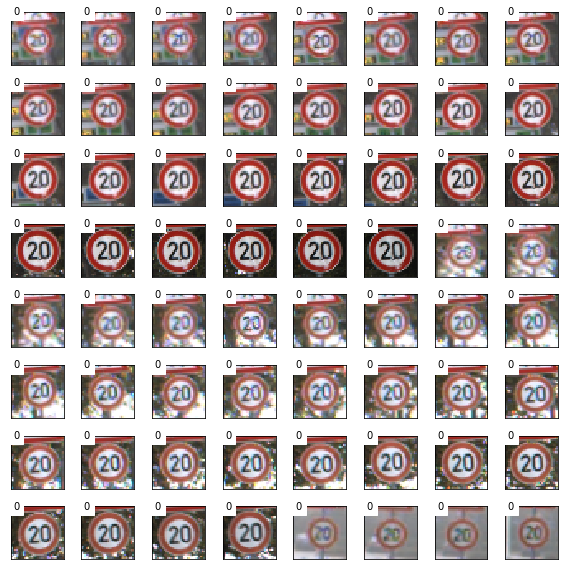

In [4]:
import matplotlib.pyplot as plt

# function displaying image with their labels
def show_image(images, idx, labels=None, cmap=None):
    size = np.ceil(np.sqrt(len(idx)))
    
    fig = plt.figure(figsize=(8,8))
    for i in range(len(idx)):
        ax = fig.add_subplot(size, size, i+1)
        ax.imshow(images[idx[i]], cmap=cmap)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if labels is not None:
            plt.text(1,1,str(labels[idx[i]]), color='k',backgroundcolor='w')
    fig.tight_layout()
        
# Visualizations will be shown in the notebook.
%matplotlib inline

show_image(X_train, range(64), y_train)

We see that the image seems to be sorted by label and that pictures seems to be from the same panel for several images. This is actually confirmed on the dataset web page ("_Each track contains 30 images of one single physical traffic sign_").

We will need to take this into account when splitting the dataset into a training and a validation set. If we take the image randomly, the validation set will include image of panel present in the training set. When selecting instance for the validation set, we will need to separate entire track of single physical traffic sign.

Note that there seems that one image is missing, if each track is supposed to be 30 pictures of the same sign, the total number of image is not a multiple of 30, there is one missing picture (at least)

### Information about classes

Let's examinate the label distribution (to confirm if the instance are ordered by labels), and also plot an histogram of the count of each labels.

The most common sign in the training set is "Speed limit (50km/h)" with 2250 instances
The least common sign in the training set is "Go straight or left" with 210 instances


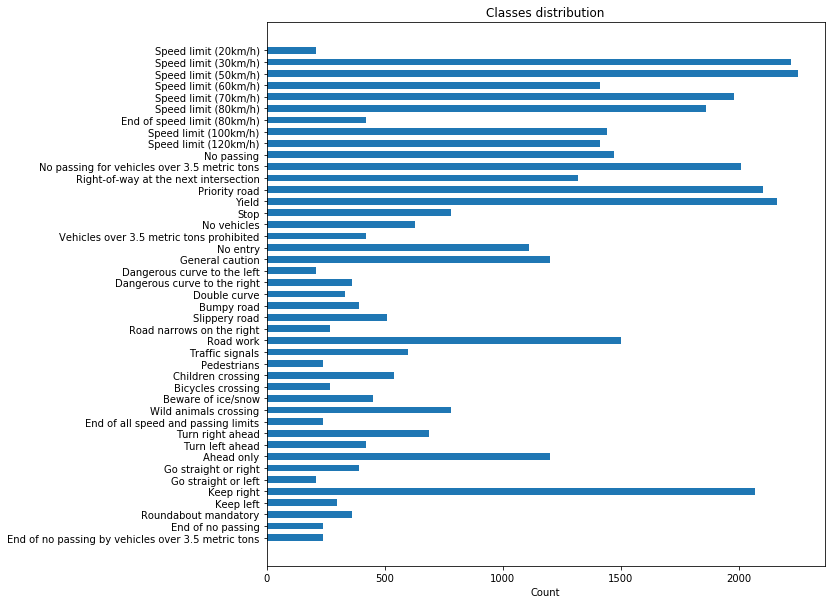

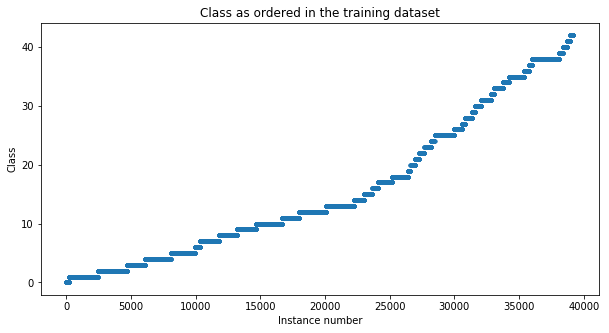

In [5]:
import collections
counter=collections.Counter(y_train)
most_common = counter.most_common()

with open('data/human_readable_label.p', mode='rb') as f:
    readable_labels = pickle.load(f)
    
print('The most common sign in the training set is "{}" with {} instances'.format(readable_labels[most_common[0][0]], most_common[0][1]))
print('The least common sign in the training set is "{}" with {} instances'.format(readable_labels[most_common[-1][0]], most_common[-1][1]))

%matplotlib inline


# display label histogram
lab = [readable_labels[x] for x in counter]
y_pos = np.arange(len(most_common))
count = [counter[x] for x in counter]

plt.figure(figsize=(10,10))
plt.gca().invert_yaxis()
plt.barh(y_pos, count, ecolor='black', height=.6)
plt.yticks(y_pos, lab)
plt.xlabel('Count')
plt.title('Classes distribution')
plt.show()


# display label distribution in the dataset
plt.figure(figsize=(10,5))
plt.plot(y_train, '.')
plt.title('Class as ordered in the training dataset')
plt.xlabel('Instance number')
plt.ylabel('Class')
plt.show()

These two plots shows us two things:

- the dataset is ordered by class. This means that we will need to be sure to randomize the order before using the data (when selecting a part of it for the validation set, and when training the network -- but in this case the randomisation is done at each loop)

- there are large difference (from ~200 to ~2000) in the number of instance per class. If we collect more data, or if we generate more data, we should focus on increasing data from classes with less images, if possible.

- we also need to be sure to include at least one track (30 images) of a panel of each classes in the validation set.

### Random image display
Let's examine image further in the dataset to have a idea of what they look like, if we can get some usefull info about them.

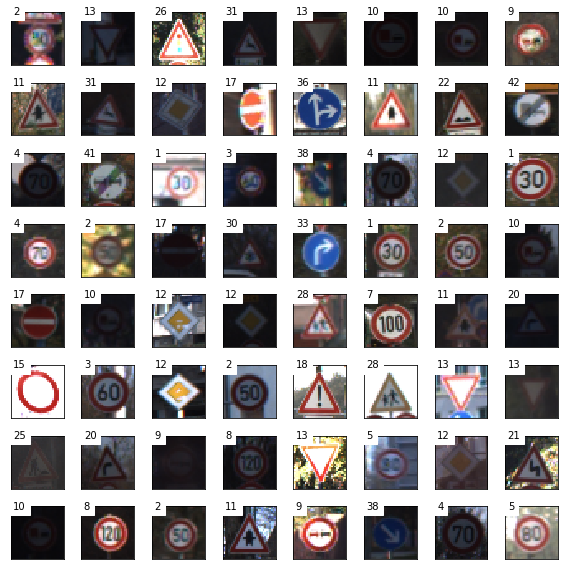

In [6]:
# initialize seed for reproductible results
np.random.seed(0)

idx = np.random.randint(0, n_train, 64)
show_image(X_train, idx, y_train)

We see that some of these pictures are quite dark. We could maybe preprocess each image to have equal mean brightness across all the dataset.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [7]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import cv2

def pre_process(dataset):
    new_dataset = np.zeros((len(dataset), 32, 32, 1))
    
    i = 0
    for img in dataset:
        img_copy = np.copy(img)
        
        # convert to YUV
        yuv_img = cv2.cvtColor(img_copy, cv2.COLOR_BGR2YUV)
        
        # equalize histogram and keep only the grayscale
        # keep only black and white
        equalised = cv2.equalizeHist(yuv_img[:,:,0])
        new_dataset[i,:,:,0] = equalised/256-.5
        i += 1
    return new_dataset

X_train_pre_proc = pre_process(X_train)
X_test_pre_proc = pre_process(X_test)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I did preprocess the data in the following way:

- I have converted the image to grayscale. I've done this because I have experimented with both the color and grayscale images. The performance on the original dataset was similar, but I was running into memory problems when adding data in the next step with the color image, so I decided to go with the grayscale.
- I equalised the histogram of each picture, to increase the contrast of the images. See the following cell for the result on different type of image
- the resulting image is "normalized" so that the features are in the [-0.5,0.5] interval

See the following image showing the effect of the histogram equalization.

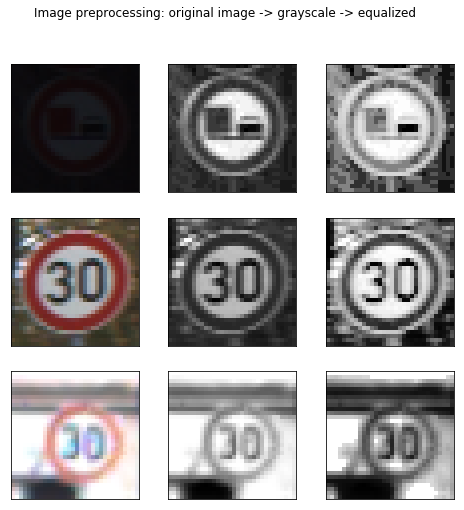

In [8]:
dark_idx = 14935
normal_idx = 1871
bright_idx = 2163

    
#    fig = plt.figure(figsize=(8,8))
#    for i in range(len(idx)):
#        ax = fig.add_subplot(size, size, i+1)
#        ax.imshow(images[idx[i]], cmap=cmap)
#        ax.axes.get_xaxis().set_visible(False)
#        ax.axes.get_yaxis().set_visible(False)
#        if labels is not None:
#            plt.text(1,1,str(labels[idx[i]]), color='k',backgroundcolor='w')
#    fig.tight_layout()

fig = plt.figure(figsize=(8,8))
fig.suptitle('Image preprocessing: original image -> grayscale -> equalized')
i=0
for idx in [dark_idx, normal_idx, bright_idx]:

    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(X_train[idx])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    yuv_img = cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2YUV)
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(yuv_img[:,:,0], cmap='gray')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    equalised = cv2.equalizeHist(yuv_img[:,:,0])
    ax = fig.add_subplot(3,3,i+3)
    ax.imshow(equalised, cmap='gray')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    i+=3


In [9]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# split into training and validation set
cur_label = -1
valid_idx = []
train_idx = []

i = 0
while i < n_train:
    # add one 30 image track to the validation set
    if cur_label != y_train[i]:
        valid_idx += list(range(i,i+30))
        cur_label = y_train[i]
        i += 30
    else:
        train_idx.append(i)
        i += 1
        
X_train_norm = X_train_pre_proc[train_idx,:,:,:]
X_valid_norm = X_train_pre_proc[valid_idx,:,:,:]
y_train_norm = y_train[train_idx]
y_valid_norm = y_train[valid_idx]

X_train_pre_proc = None

In [10]:
# generate new data
# possible way: rotation, translation, scale
import random

def rotate_and_scale(img, angle=0, scale=1):
    rows,cols,depth = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2),angle,scale)
    return cv2.warpAffine(img,M,(cols,rows))

def translate(img, vector=(0,0)):
    rows,cols, *dummy = img.shape
    M = np.float32([[1,0,vector[0]],[0,1,vector[1]]])
    return cv2.warpAffine(img,M,(cols,rows))

def transform_image(img):
    angle_range = (-10., 10.)
    scale_range = (.9,1.1)
    trans_range = (-2,3)      # 3 because randint give a <= X < b
    
    angle = random.uniform(*angle_range)
    scale = random.uniform(*scale_range)
    trans = np.random.randint(*trans_range, (2))
    
    img2 = rotate_and_scale(img, angle=angle, scale=scale)
    return translate(img2, vector=trans)

def create_data(data, labels):
    inflate = 4
    
    nb,w,h,d = X_train_norm.shape
    new_data = np.zeros((inflate*nb, w, h, d))
    new_label = np.zeros((inflate*nb))

    j = 0
    for img,label in zip(X_train_norm,labels):
        for i in range(inflate):
            new_data[j,:,:,0] = transform_image(img)
            new_label[j] = label
            j+=1

    a = np.vstack([data, new_data])
    b = np.concatenate([labels, new_label])
    
    return a,b
            
X_train_norm_inflated, y_train_norm_inflated = create_data(X_train_norm, y_train_norm)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

#### Training/Validation/Test setup

I have splitted the training set into a training set and a validation set. I have selected the first 30 images for each label as validation example. These 30 images correspond to picture of the same physical sign, as described in the dataset documentation. I've chosen to to so instead of taking random images, because by doing so, it would generate a validation set that contains the same physical sign than the training set, and I would not see overfitting when checking the accuracy on the validation set.

The test set is the test set included in the dataset.

#### Additional data generation

I've generated new data for the training set by doing small geometric transformations on the existing images. I've used the following three transformation, combined:

- small rotation (angle randomly chosen from -10 deg to 10 deg)
- image scaling (random scale factor from .9 to 1.1)
- image translation (up to 2 pixels in any directions)

The following cell shows the effect of these transformation

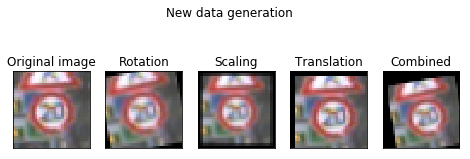

In [11]:
fig = plt.figure(figsize=(8,3))
fig.suptitle('New data generation')

img = np.copy(X_train[0])

ax = fig.add_subplot(1,5,1)
ax.imshow(img)
plt.title('Original image')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
    
# rotation
img_r = rotate_and_scale(img, angle=10, scale=1)
ax = fig.add_subplot(1,5,2)
ax.imshow(img_r)
plt.title('Rotation')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# scale
img_s = rotate_and_scale(img, angle=0, scale=.9)
ax = fig.add_subplot(1,5,3)
ax.imshow(img_s)
plt.title('Scaling')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# translation
img_t = translate(img, vector=(2,2))
ax = fig.add_subplot(1,5,4)
ax.imshow(img_t)
plt.title('Translation')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# translation
img_c = translate(rotate_and_scale(img,angle=10, scale=.9), vector=(2,2))
ax = fig.add_subplot(1,5,5)
ax.imshow(img_c)
plt.title('Combined')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)


In [12]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def network(x, dropout):
    # Based on Lenet network, and then modified with trial and error process
    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 30x30x25
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 25), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(25))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Relu Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 30x30x25. Output = 15*15*25
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, dropout)

    # Layer 2: Convolutional. Output = 11x11x50
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 25, 50), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(50))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Relu Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Output = 5*5*50
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, dropout)

    # Flatten. Input = 5*5*50. Output = 1250.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1250. Output = 300
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1250, 300), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(300))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 300. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(300, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = n_classes (43)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture look like this:

* Input layer (32*32*1 grayscale image)
* First convolution layer:
    - filter size of 3 and depth of 25, with valid padding and relu activation function (stride = 1)
    - Maxpool layer with a stride of two
    - Dropout layer
* Second convolution layer:
    - filter size of 5 and depth of 50, with valid padding and relu activation function (stride = 1)
    - Maxpool layer with a stride of two
    - Dropout layer
* First fully connected layer with a relu activation. Input size = 1250, output size = 300
* Second fully connected layer with a relu activation. Input size = 300, output size = 84
* Output layer. Input size = 84, output size = 43

In [13]:
### Train your model here.
### Feel free to use as many code cells as needed.

# hyper parameters
EPOCHS = 20
BATCH_SIZE = 256
rate = 0.001
training_dropout = .5

In [14]:
# Needed placeholder, one hot labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
dropout = tf.placeholder(tf.float32, None)

In [15]:
# Create the network, optimization and training, accuration
logits = network(x, dropout)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver(max_to_keep=30)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout:1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
# Train the model (with some feedback while running)
val_acc = []
train_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_norm_inflated)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_norm_inflated, y_train_norm_inflated = shuffle(X_train_norm_inflated, y_train_norm_inflated)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_norm_inflated[offset:end], y_train_norm_inflated[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout:training_dropout})
            
        val_acc.append(evaluate(X_valid_norm, y_valid_norm))
        train_acc.append(evaluate(X_train_norm_inflated, y_train_norm_inflated))
        print("EPOCH {} ...".format(i+1), "Val acc = {:.3f}".format(val_acc[-1]), "Train acc = {:.3f}".format(train_acc[-1]))
        
    saver.save(sess, './network')
    print("Model saved")
    

Training...

EPOCH 1 ... Val acc = 0.845 Train acc = 0.906
EPOCH 2 ... Val acc = 0.910 Train acc = 0.960
EPOCH 3 ... Val acc = 0.905 Train acc = 0.975
EPOCH 4 ... Val acc = 0.927 Train acc = 0.984
EPOCH 5 ... Val acc = 0.931 Train acc = 0.988
EPOCH 6 ... Val acc = 0.938 Train acc = 0.990
EPOCH 7 ... Val acc = 0.955 Train acc = 0.992
EPOCH 8 ... Val acc = 0.943 Train acc = 0.994
EPOCH 9 ... Val acc = 0.952 Train acc = 0.994
EPOCH 10 ... Val acc = 0.954 Train acc = 0.996
EPOCH 11 ... Val acc = 0.953 Train acc = 0.995
EPOCH 12 ... Val acc = 0.954 Train acc = 0.997
EPOCH 13 ... Val acc = 0.957 Train acc = 0.998
EPOCH 14 ... Val acc = 0.955 Train acc = 0.998
EPOCH 15 ... Val acc = 0.958 Train acc = 0.998
EPOCH 16 ... Val acc = 0.957 Train acc = 0.998
EPOCH 17 ... Val acc = 0.947 Train acc = 0.998
EPOCH 18 ... Val acc = 0.957 Train acc = 0.999
EPOCH 19 ... Val acc = 0.958 Train acc = 0.999
EPOCH 20 ... Val acc = 0.957 Train acc = 0.999
Model saved


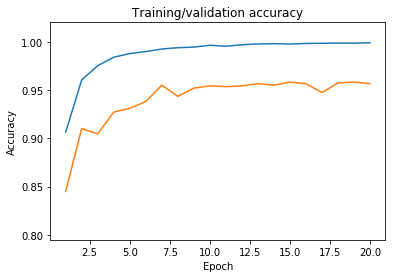

In [17]:
# Plot the accuracy on training and validation set
%matplotlib inline
# display label distribution in the dataset
plt.figure()
plt.plot(list(range(1,len(train_acc)+1)), train_acc)
plt.plot(list(range(1,len(val_acc)+1)), val_acc)
plt.ylim([min(val_acc)-.05,1.02])
plt.title('Training/validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
# To execute only after final training
with tf.Session() as sess:
    saver.restore(sess, './network')
    test_accuracy = evaluate(X_test_pre_proc, y_test)
    print('Accuracy on test set: {:.2f}%'.format(test_accuracy*100))

Accuracy on test set: 96.86%


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I've used the AdamOptimizer with a batchsize of 256, 20 epochs. The learning rate is set to 0.001 and the dropout rate in the two dropout layer is set to 0.5. The plot of the training and validation accuracy vs epochs shows me that I could have used less epochs, maybe 10 or 15 and get the same level of accuracy.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I've started with LeNet architecture that we have seen in the LeNet lab. From there, it has been a trial and error approach. Firstly I did adapt it to the current problem structure.

At the begining, I did change the input shape from 32x32x1 to 32x32x3 to take into account the 3 color channel, and I also adapted the output layer to include 43 classes. After doing some try, I decided to preprocess the data to use grayscale images. The results that I had were not significatively different, and I decided to keep this grayscale option.

I've then added the dropout layers after the convolution, to experiment a little with this concept, and it did worked well.

I've tested several depths and the filter sizes for the convolution filters and size for the fully connected layers, and the final one seems to work fine. It must be possible to do it better, but I don't have enough experiences yet with neural networks to fully justify my choices or to know in which directions I should change my current parameters.

The accuracy obtained on the test set (around 96%) seems good for this task in the context of this project (I haven't reached the same level than professional scientists who have participed to the challenge on this data set, of course)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [19]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [20]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.